In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
import re
import warnings
warnings.filterwarnings('ignore')

Source of data: https://www.kaggle.com/code/poojag718/sentiment-analysis-machine-learning-approach/input

In [2]:
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', delimiter=',', encoding='ISO-8859-1')
df.columns = ['Sentiment','id','date','query','user','text']
df.head()

,Sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


We're only interested in 2 text columns:

In [3]:
df = df[['Sentiment','text']]

Those columns have no missing values:

In [4]:
df.isna().sum().sum()

0

After checking the target feature I find it's necessary to rebalance the categories as well as it may be helpful to use 0,1 as category values:

In [5]:
df.Sentiment.value_counts()

Sentiment
0    799996
4    248576
Name: count, dtype: int64

In [6]:
df['Sentiment'] = df['Sentiment'].replace({4:1})

In [7]:
df.Sentiment.value_counts()

Sentiment
0    799996
1    248576
Name: count, dtype: int64

In [8]:
from sklearn.utils import resample

In [9]:
## majority class 0
df_majority = df[df['Sentiment']==0]
## minority class 1
df_minority = df[df['Sentiment']==1]

In [10]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,   
                                 n_samples=len(df_minority),    
                                 random_state=1234) 

In [11]:
df = pd.concat([df_majority_downsampled, df_minority])

In [12]:
df.Sentiment.value_counts()

Sentiment
0    248576
1    248576
Name: count, dtype: int64

Starting preprocessing with downloading nltk data:

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/piotr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/piotr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Stopwords need to be deleted as well as 'quot' which is meaningless and should be treated as stopword as well:

In [14]:
words_to_be_removed = list(stopwords.words('english'))+list(punctuation)+["quot"]

To clean the datasets we can use following auxilary functions:

In [15]:
def clean_data(input_text):
    text = re.sub('[^a-zA-Z]', ' ', input_text)
    #Convert to lowercase
    text = text.lower()
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    return text

lem = WordNetLemmatizer()
def lemmitize_and_remove(input_text):
    text = [lem.lemmatize(word) for word in input_text if not word in words_to_be_removed]
    text_joined = " ".join(text)
    return text_joined

In [16]:
data_cleaned = df.copy()

In [17]:
data_cleaned.text = df.text.apply(clean_data).apply(lemmitize_and_remove)

In [18]:
data_cleaned = data_cleaned.reindex(np.random.permutation(data_cleaned.index))

In [19]:
data_cleaned.head()

,Sentiment,text
385113,0,ouch reinstallaion went really bad know recove...
955942,1,im recovering friend st bday last nite today i...
1038673,1,undefeated goodnight sweet dream
584122,0,nothing dooo
40699,0,jakicullen angiesheep excited set visit well a...


Tokenize and frequency dictionary:

In [29]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

words_tokenized = word_tokenize(" ".join(list(data_cleaned['text'].values)))

[nltk_data] Downloading package punkt to /home/piotr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
frequency_distribution = FreqDist(words_tokenized)

Below is snippet of 20 most common words from frequency distribution table:

In [31]:
frequency_distribution.most_common(20)

[('day', 36071),
 ('good', 29227),
 ('get', 26548),
 ('like', 24919),
 ('go', 24132),
 ('http', 22302),
 ('u', 22166),
 ('work', 21726),
 ('today', 21584),
 ('got', 21452),
 ('love', 20672),
 ('time', 20560),
 ('going', 19849),
 ('one', 17949),
 ('lol', 17915),
 ('back', 17537),
 ('know', 16866),
 ('com', 16310),
 ('im', 16117),
 ('really', 15652)]

Now we can depict sentiment on cloudwords:

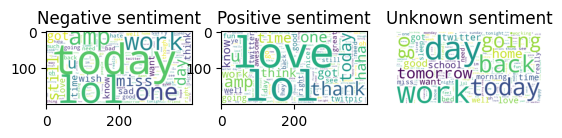

In [180]:
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

negative_sent = ",".join(list(data_cleaned[data_cleaned['Sentiment']==0]['text'].values))
positive_sent = ",".join(list(data_cleaned[data_cleaned['Sentiment']==1]['text'].values))
both_sent = ",".join(set(list(data_cleaned[data_cleaned['Sentiment']==0]['text'].values)).intersection(list(data_cleaned[data_cleaned['Sentiment']==1]['text'].values)))

plt.figure()
plt.subplot(1, 3, 1).set_title("Negative sentiment")
plt.plot()
plt.imshow(wordcloud.generate(negative_sent))
plt.subplot(1, 3, 2).set_title("Positive sentiment")
plt.plot()
plt.imshow(wordcloud.generate(positive_sent))
plt.subplot(1, 3, 3).set_title("Unknown sentiment")
plt.plot()
plt.imshow(wordcloud.generate(both_sent))
plt.axis("off")
plt.show()
# Visualize the word cloud
#wordcloud.to_image()

In [181]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
from keras import regularizers

We split the datasets into training and test datasets:

In [183]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned.text, data_cleaned.Sentiment, test_size=0.2, random_state=137)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 397721
# Test data samples: 99431


In [182]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 30  # Maximum number of words in a sequence

And perform tokenization - filters may not be applicable because data had already been cleared out

In [184]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

We can tell that size of the sequence varies and we need to make it constant:

In [68]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    397721.000000
mean          7.697831
std           3.952493
min           1.000000
25%           5.000000
50%           7.000000
75%          11.000000
max          36.000000
Name: text, dtype: float64

In [69]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [70]:
lengths = np.apply_along_axis(len, 1,X_train_seq_trunc)
print(f"min length {min(lengths)} max length {max(lengths)} ")

min length 30 max length 30 


Then we set labels on target feature and apply one hot encoding:

In [71]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

We split the dataset one more time into training and validation subsets:

In [185]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (39773, 30)


With following auxilary functions for compiling and training the model:

In [121]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and
    batch_size are set by the constants at the top of the
    notebook.

    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])

    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric.
    Training and validation metric are plotted in a
    line chart for each epoch.

    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.

    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)

    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.

    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series

    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series
    '''
    return re.sub(r'@\w+', '', input_text)

Let's try to evaluate simple network:

In [73]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 embedding_4 (Embedding)     (None, 30, 8)             80000     
                                                                 
 flatten_4 (Flatten)         (None, 240)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 482       
                                                                 
Total params: 80,482
Trainable params: 80,482
Non-trainable params: 0
_________________________________________________________________


In [74]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Epoch 1/20
700/700 [==============================] - 1s 1ms/step - loss: 0.5706 - accuracy: 0.7106 - val_loss: 0.4973 - val_accuracy: 0.7588
Epoch 2/20
700/700 [==============================] - 1s 1ms/step - loss: 0.4837 - accuracy: 0.7700 - val_loss: 0.4828 - val_accuracy: 0.7675
Epoch 3/20
700/700 [==============================] - 1s 1ms/step - loss: 0.4712 - accuracy: 0.7777 - val_loss: 0.4792 - val_accuracy: 0.7706
Epoch 4/20
700/700 [==============================] - 1s 1ms/step - loss: 0.4645 - accuracy: 0.7823 - val_loss: 0.4785 - val_accuracy: 0.7696
Epoch 5/20
700/700 [==============================] - 1s 1ms/step - loss: 0.4593 - accuracy: 0.7854 - val_loss: 0.4763 - val_accuracy: 0.7726
Epoch 6/20
700/700 [==============================] - 1s 1ms/step - loss: 0.4547 - accuracy: 0.7884 - val_loss: 0.4785 - val_accuracy: 0.7723
Epoch 7/20
700/700 [==============================] - 1s 1ms/step - loss: 0.4504 - accuracy: 0.7916 - val_loss: 0.4778 - val_accuracy: 0.7722
Epoch 

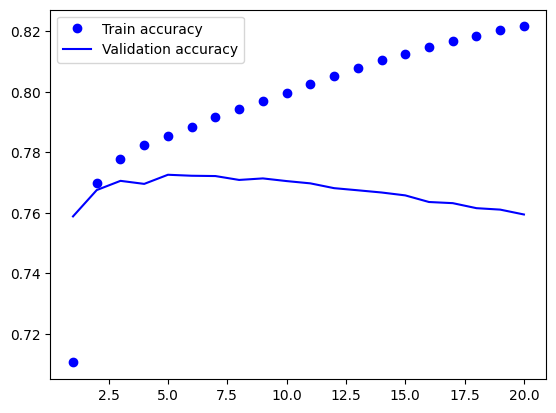

In [75]:
eval_metric(emb_history, 'accuracy')

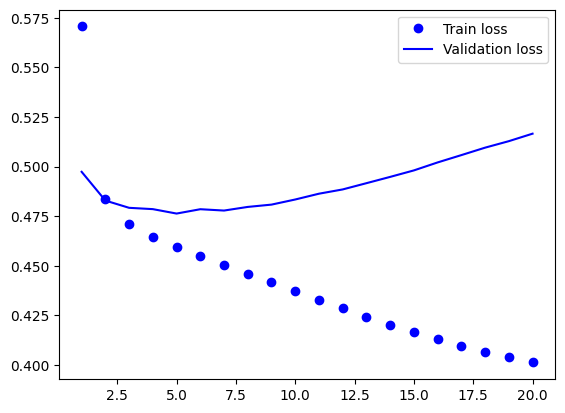

In [76]:
eval_metric(emb_history, 'loss')

As we can see, result is not the best one, indicating some overfitting, what's worse, the results got worse as the epochs progressed. After several attempts this model yielded best results:

In [113]:
emb_model_7 = models.Sequential()
emb_model_7.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model_7.add(layers.BatchNormalization())
emb_model_7.add(layers.SpatialDropout1D(0.5))
emb_model_7.add(layers.LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
emb_model_7.add(layers.Dropout(0.5))

#emb_model_4.add(layers.Dense(32, activation='relu'))
emb_model_7.add(layers.Flatten())
emb_model_7.add(layers.Dense(2, activation='softmax'))
emb_model_7.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 30, 8)             80000     
                                                                 
 batch_normalization_6 (Batc  (None, 30, 8)            32        
 hNormalization)                                                 
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 30, 8)            0         
 lDropout1D)                                                     
                                                                 
 lstm_16 (LSTM)              (None, 30, 32)            5248      
                                                                 
 dropout_13 (Dropout)        (None, 30, 32)            0         
                                                                 
 flatten_20 (Flatten)        (None, 960)             

In [114]:
emb_history_7 = deep_model(emb_model_7, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Epoch 1/20
700/700 [==============================] - 16s 21ms/step - loss: 0.5918 - accuracy: 0.6758 - val_loss: 0.4994 - val_accuracy: 0.7598
Epoch 2/20
700/700 [==============================] - 15s 21ms/step - loss: 0.5182 - accuracy: 0.7460 - val_loss: 0.4990 - val_accuracy: 0.7599
Epoch 3/20
700/700 [==============================] - 15s 21ms/step - loss: 0.5041 - accuracy: 0.7558 - val_loss: 0.4813 - val_accuracy: 0.7696
Epoch 4/20
700/700 [==============================] - 15s 21ms/step - loss: 0.4972 - accuracy: 0.7614 - val_loss: 0.4772 - val_accuracy: 0.7712
Epoch 5/20
700/700 [==============================] - 15s 21ms/step - loss: 0.4941 - accuracy: 0.7627 - val_loss: 0.4727 - val_accuracy: 0.7717
Epoch 6/20
700/700 [==============================] - 15s 21ms/step - loss: 0.4894 - accuracy: 0.7654 - val_loss: 0.4811 - val_accuracy: 0.7719
Epoch 7/20
700/700 [==============================] - 15s 21ms/step - loss: 0.4883 - accuracy: 0.7664 - val_loss: 0.4721 - val_accuracy:

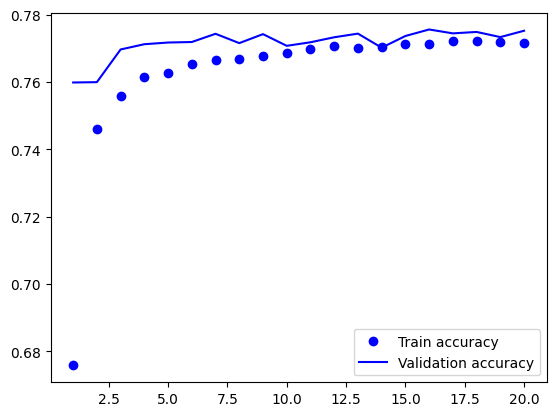

In [115]:
eval_metric(emb_history_7, 'accuracy')

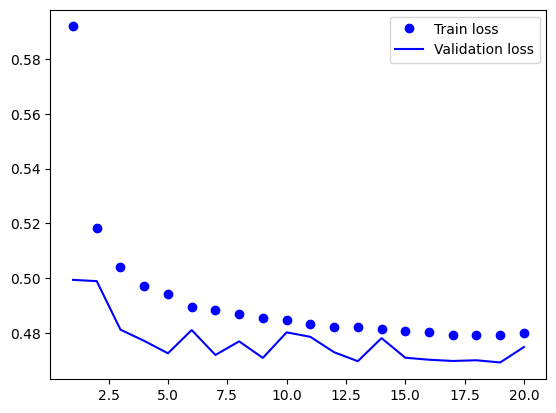

In [116]:
eval_metric(emb_history_7, 'loss')

We can see accuracy levels are very similar to the first model, but we managed to avoid overfitting and achieved stable (not growing) learning curve. 
Model accuracy is 77.6%, similar to Kaggle results achieved with different algorithms.

In [118]:
emb_model_7.evaluate(X_test_seq_trunc,y_test_oh)

3108/3108 [==============================] - 10s 3ms/step - loss: 0.4754 - accuracy: 0.7755


[0.47543156147003174, 0.7755327820777893]

In [ ]:
!mkdir -p saved_model
emb_model_7.save('saved_model/final')